# Change map classification

In [88]:
from auxil.eeSar_seq import run
run()

Map(basemap={'url': 'https://{s}.tile.openstreetmap.org/{z}/{x}/{y}.png', 'max_zoom': 19, 'attribution': 'Map …

In [2]:
%matplotlib inline
import ee, time
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np
from osgeo import gdal
from osgeo.gdalconst import GA_ReadOnly,GDT_Float32,GDT_Byte
import matplotlib.pyplot as plt

ee.Initialize()

In [42]:
class Dnn_keras(object):    
    '''High-level TensorFlow (keras) Dnn classifier'''
    def __init__(self,Gs,ls,Ls,epochs=100):
#      setup the network architecture  
        self._Gs = Gs   
        n_classes = ls.shape[1]
        self._labels = ls
        self._epochs = epochs
        self._dnn = tf.keras.Sequential()
#      hidden layers        
        for L in Ls:
            self._dnn \
             .add(layers.Dense(L,activation='relu'))
#      output layer
        self._dnn \
          .add(layers.Dense(n_classes,
                            activation='softmax'))       
#      initialize                             
        self._dnn.compile(
         optimizer=tf.compat.v1.train.GradientDescentOptimizer(0.01),
                 loss='categorical_crossentropy')
        
    def train(self):
        try:           
            self._dnn.fit(self._Gs,self._labels,
                        epochs=self._epochs,verbose=0)
            return True 
        except Exception as e:
            print( 'Error: %s'%e )
            return None             
        
    def classify(self,Gs):     
#      predict new data                       
        Ms = self._dnn.predict(Gs)
        cls = np.argmax(Ms,1)+1
        return (cls,Ms)

    def test(self,Gs,ls):
        m = np.shape(Gs)[0]
        classes, _ = self.classify(Gs)
        classes = np.asarray(classes,np.int16)
        labels = np.argmax(np.transpose(ls),axis=0)+1
        misscls = np.where(classes-labels)[0]
        return len(misscls)/float(m)  

In [89]:
# create a labeled change map using AAFC/ACI for 2017 near Regina
bmap = ee.Image('users/mortcanty/reginasmall2017') \
           .select(ee.List.sequence(3,17))
crop2017 = ee.ImageCollection('AAFC/ACI') \
    .filter(ee.Filter.date('2017-01-01', '2017-12-31')) \
    .first() \
    .clip(bmap.geometry())
labeled_bmap = ee.Image.cat(bmap,crop2017)

print( labeled_bmap.bandNames().getInfo() )

['T20170423_2', 'T20170505_3', 'T20170517_4', 'T20170529_5', 'T20170610_6', 'T20170622_7', 'T20170716_8', 'T20170728_9', 'T20170809_10', 'T20170821_11', 'T20170902_12', 'T20170914_13', 'T20170926_14', 'T20171008_15', 'T20171020_16', 'landcover']


In [5]:
# export to GEE for inspection
assexport = ee.batch.Export.image.toAsset(labeled_bmap,
                  description='assetExportTask', 
                  assetId='users/mortcanty/labeled_bmap',scale=10,maxPixels=1e9)
print('Exporting labeled bmap to %s\n task id: %s'%('users/mortcanty/labeled_bmap',str(assexport.id)))
assexport.start()

Exporting labeled bmap to users/mortcanty/labeled_bmap
 task id: SWQ362K55KMXRRYJ5X4I3LKQ


In [90]:
# export to drive for downloading
drexport = ee.batch.Export.image.toDrive(labeled_bmap,
                  description='driveExportTask', 
                  folder = 'EarthEngineImages',
                  fileNamePrefix='labeled_bmap',scale=10,maxPixels=1e9)
print('Exporting labeled bmap to %s\n task id: %s'%('users/mortcanty/labeled_bmap',str(drexport.id)))
drexport.start()

Exporting labeled bmap to users/mortcanty/labeled_bmap
 task id: VMFJEDTGBUD7A6FEEP4GZNTZ


In [93]:
!ls myimagery/

dualpol_bmap.tif	  labeled_bmap.tif
dualpol_bmap.tif.aux.xml  users-users-mortcanty-time_test_01.tif
dualpol_cmap.tif	  users-users-mortcanty-time_test_02.tif
dualpol_fmap.tif	  users-users-mortcanty-time_test_03.tif
dualpol_smap.tif	  users-users-mortcanty-time_test_04.tif


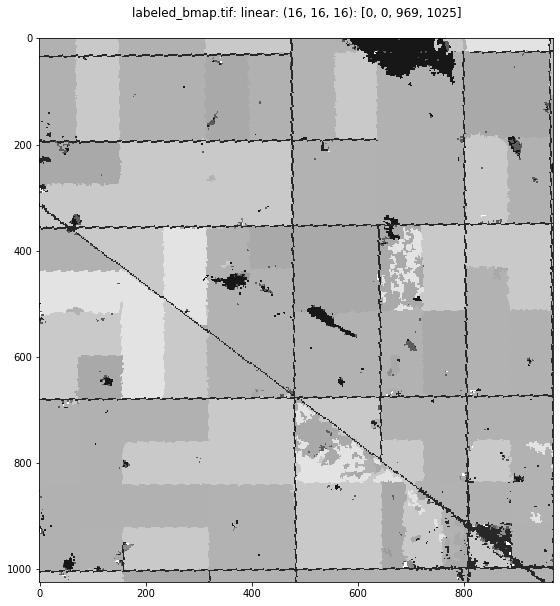

<Figure size 432x288 with 0 Axes>

In [125]:
%run scripts/dispms -f myimagery/labeled_bmap.tif -p [16,16,16] -e 2

In [20]:
gdal.AllRegister()                   
inDataset = gdal.Open('myimagery/labeled_bmap.tif',GA_ReadOnly)
cols = inDataset.RasterXSize
rows = inDataset.RasterYSize    
bands = inDataset.RasterCount
labeled_bmap = np.zeros((rows*cols,bands))                              
for b in range(bands):
    band = inDataset.GetRasterBand(b+1)
    labeled_bmap[:,b]=band.ReadAsArray(0,0,cols,rows).ravel()
driver = inDataset.GetDriver()     
inDataset = None
m = labeled_bmap.shape[0]
print(m)

993225


In [22]:
classnums = list(set(labeled_bmap[:,15]))
classnums.sort()
print(classnums)

[0.0, 20.0, 30.0, 34.0, 80.0, 110.0, 122.0, 133.0, 146.0, 153.0, 154.0, 158.0, 174.0, 196.0, 220.0]


In [23]:
i=0
labels = labeled_bmap[:,15]
for c in classnums:
    labels = np.where(labels==c,i,labels)
    i += 1  
labels = np.array(labels,dtype=np.uint8)    
print(labels[1000:1050])
print(set(labels))

[ 9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9
  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9 12 12 12 12 12 12 12 12 12
 12 12]
{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14}


In [16]:
classnames = "['nc','water','barren','urban','wetland','grassland','pasture','barley','spring wheat','rapeseed','flax','soybeans','lentils','canaryseed','broadleaf']"

In [24]:
outDataset = driver.Create('myimagery/labels.tif',cols,rows,1,GDT_Byte)
outBand = outDataset.GetRasterBand(1)
outBand.WriteArray(np.reshape(labels,(rows,cols)))
outBand.FlushCache()
outDataset = None

In [33]:
# random subset for training
n = 100000
idx = np.random.permutation(m)[0:n]
# training vectors normalized -1 to 1 
Xs = labeled_bmap[idx,0:15]
Xs = Xs/3.0
# one hot encoded class labels
Ls = np.array(labels[idx],dtype=np.int)
print(Ls[0:5])
ls = np.zeros((n,15))
for i in range(n):
    ls[i,Ls[i]]=1.0
print(ls[0:5,:])

[12 10 10 10 12]
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]]


In [45]:
start = time.time()
classifier = Dnn_keras(Xs,ls,[10,10,10],100)
classifier.train()
print('time: %s'%str(time.time()-start))

time: 291.3675901889801


In [46]:
classifier.test(Xs,ls)

0.41958

In [47]:
cls,Ms = classifier.classify(labeled_bmap[:,0:15]/3.0)                       

In [48]:
outDataset = driver.Create('myimagery/class.tif',cols,rows,1,GDT_Byte)
outBand = outDataset.GetRasterBand(1)
outBand.WriteArray(np.reshape(cls,(rows,cols)))
outBand.FlushCache()
outDataset = None

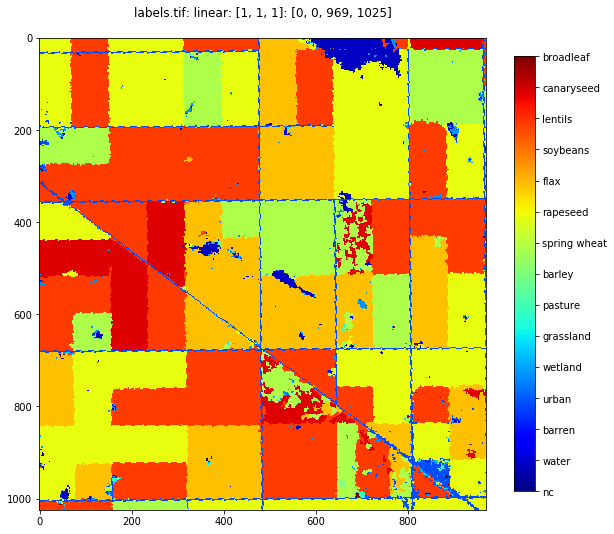

In [38]:
%run scripts/dispms -f myimagery/labels.tif -c -r "['nc','water','barren','urban','wetland','grassland','pasture','barley','spring wheat','rapeseed','flax','soybeans','lentils','canaryseed','broadleaf']"

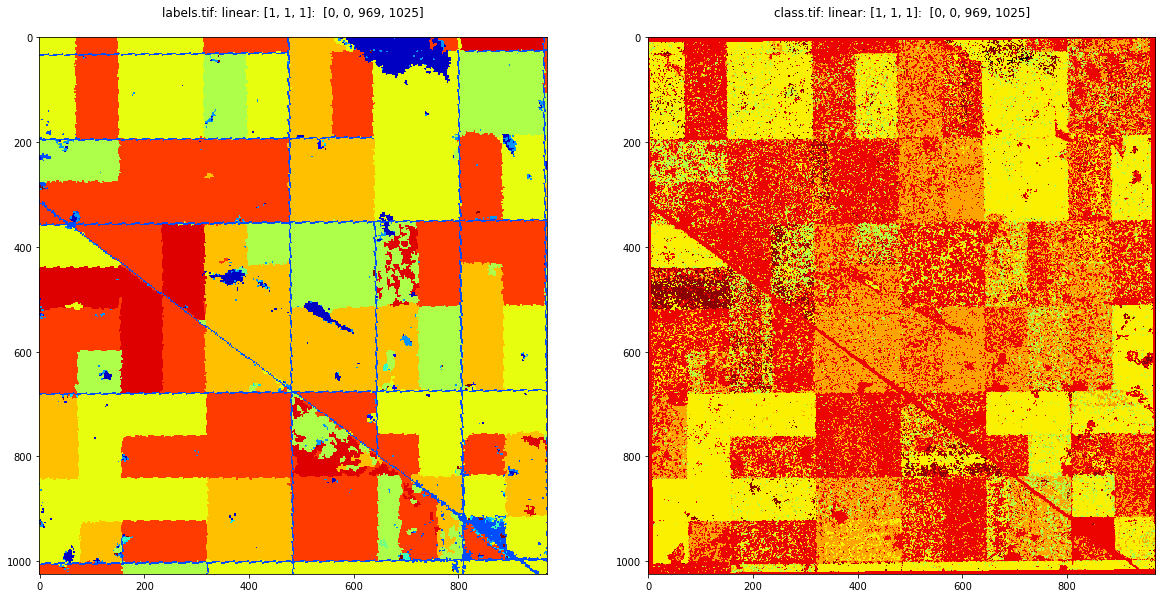

In [50]:
%run scripts/dispms -f myimagery/labels.tif -c -F myimagery/class.tif -C -s 'myimagery/compare.png'